<a href="https://colab.research.google.com/github/phbez/m_s/blob/main/Metal_Surface_Test_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importação das bibliotecas

In [5]:
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels


2. Carregando o dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
folder='/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01'

3. Estruturando o dataset

In [8]:
#image resolution
image_width = 48
image_height = 48
channels = 3 #rgb

train_files = []
#i=0
for classes in ['Crazing', 'Scratches']:
    print(os.path.join(folder, classes))
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f ))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/Crazing
/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/Scratches


In [9]:
i = 0
for classes in ['Crazing', 'Scratches']:
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f))]
    for _file in onlyfiles:
        img_path = os.path.join(folder, classes, _file)
        img = load_img(img_path, target_size=(image_height, image_width))
        x = img_to_array(img)
        dataset[i] = x
        mapping = {'Crazing': 0 , 'Scratches': 1}
        y_dataset.append(mapping[classes])
        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")

All images to array!


6. Normalizando os dados

In [10]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

In [11]:
classes = ['Crazing', 'Scratches']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

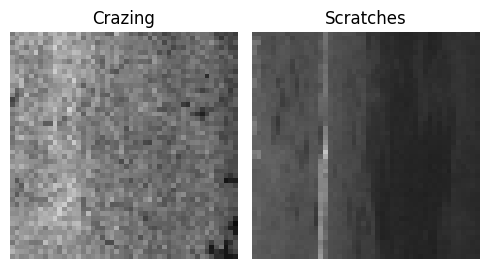

In [12]:
# Cria uma figura com uma grade de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 15))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx]

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='Spectral')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()

7. Normalizando o dataset

In [13]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

2


In [14]:
# Ajusta o tamanho do dataset para coincidir com o tamanho menor entre dataset_trimmed e y_dataset_
min_length = min(len(dataset), len(y_dataset_))
dataset_trimmed = dataset[:min_length]
y_dataset_trimmed = y_dataset_[:min_length]

# Verifica se os tamanhos agora estão iguais
assert len(dataset_trimmed) == len(y_dataset_trimmed), "Os tamanhos ainda não são consistentes!"

# Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_trimmed, test_size=0.2)

print("Train set size: {}, Test set size: {}".format(len(X_train), len(X_test)))


Train set size: 441, Test set size: 111


In [15]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 5000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

Tamanho do conjunto de treinamento balanceado: 10000
Tamanho do conjunto de teste: 111
Classe 0: 5000 amostras
Classe 1: 5000 amostras


In [16]:
# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 3)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(2, activation='softmax'))  # Especifica 'softmax' como a função de ativação

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 48, 48, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 512)         │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,179,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,373,998 (9.06 MB)

 Trainable params: 2,373,992 (9.06 MB)

 Non-trainable params: 6 (24.00 B)

4. Compilando o modelo

In [17]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Treinar o modelo
history = model.fit(balanced_X_train, balanced_y_train,validation_split= 0.2, epochs=100, callbacks=[early_stopping], batch_size=64)


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.8442 - loss: 0.4192 - val_accuracy: 0.5010 - val_loss: 2.5262
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9846 - loss: 0.0528 - val_accuracy: 0.9105 - val_loss: 0.2647
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 1.0000 - loss: 6.5539e-04 - val_accuracy: 1.0000 - val_loss: 2.1783e-05
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9950 - loss: 0.0180 - val_accuracy: 0.9970 - val_loss: 0.0069
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9966 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 2.6262e-05
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 8.7759e-06
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.

In [18]:
val_accuracy = history.history['val_accuracy']

mean_val_accuracy = np.mean(val_accuracy)

print("Valor médio de acurácia:", mean_val_accuracy)

Valor médio de acurácia: 0.9709423092695383


5. Carregando o modelo

In [19]:
import pandas as pd
from google.colab import drive


In [ ]:
# Mount Google Drive (add this line)
drive.mount('/content/drive')

In [ ]:
# START OF SAVING CODE
# Save training history
history_save = pd.DataFrame(history.history)
#history_save.to_csv('datasetNormal.csv') # old: temporarily saving
history_save.to_csv('/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/The_Model_Metal_Surfaces_v01/datasetNormal.csv')  # Changed path to Google Drive

**Save model structure in JSON file**

In [22]:
model_json = model.to_json()
#with open("metal_surface_model.json", "w") as json_file: # old: temporarily saving
with open("/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/The_Model_Metal_Surfaces_v01/metal_surface_model.json", "w") as json_file:  # Changed path
    json_file.write(model_json)

**Save complete model**

In [23]:
#model.save('modelosalvo.keras') # old: temporarily saving
model.save('/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/The_Model_Metal_Surfaces_v01/modelosalvo.keras')  # Changed path
# END OF SAVING CODE

**Load model (for verification or immediate use)**

In [24]:
from keras.models import load_model
modelo_carregado = load_model('/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/The_Model_Metal_Surfaces_v01/modelosalvo.keras')

**Load history**

In [25]:
import pandas as pd
history = pd.read_csv('/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/The_Model_Metal_Surfaces_v01/datasetNormal.csv')

6. Plotando o modelo

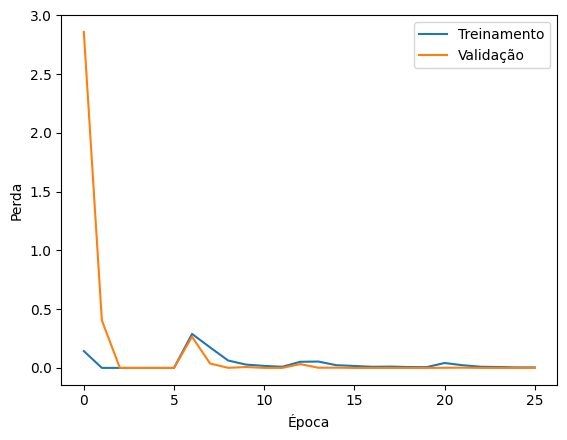

In [26]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])


plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc = 'upper right')
plt.show()

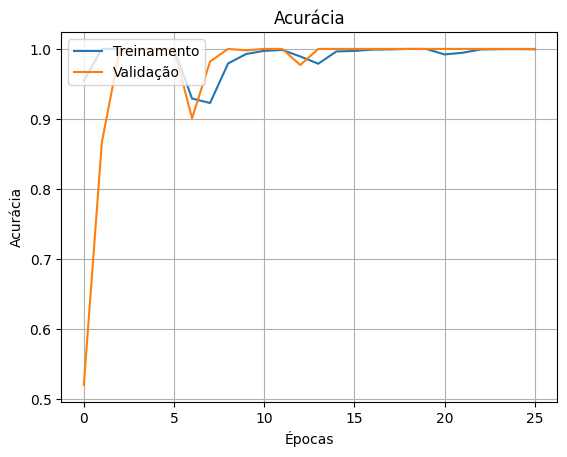

In [27]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.grid(True)
plt.show()
plt.close()

7. Salvando o modelo

In [28]:
preds = modelo_carregado.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step


In [29]:
#Função da Matriz de Confusão

def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues
    ):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

Confusion matrix, without normalization
[[60  0]
 [ 0 51]]


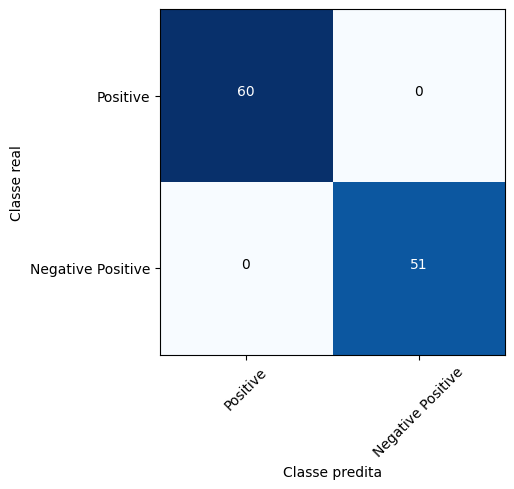

In [30]:
#Gráfico da Matriz de Confusão

y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plot_confusion_matrix(cm, classes=['Positive', 'Negative Positive'], title='Confusion matrix')
plt.show()
plt.close()

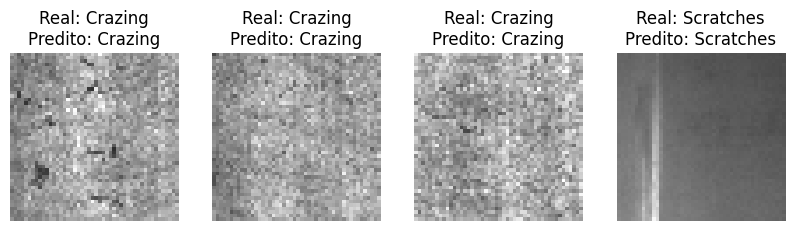

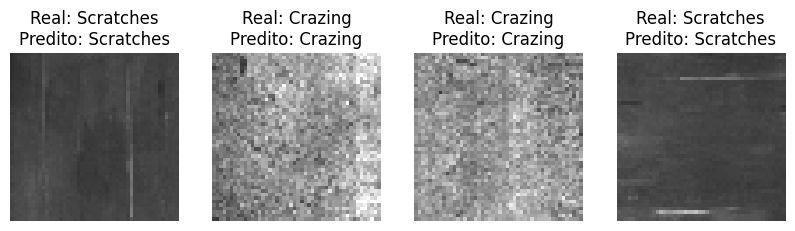

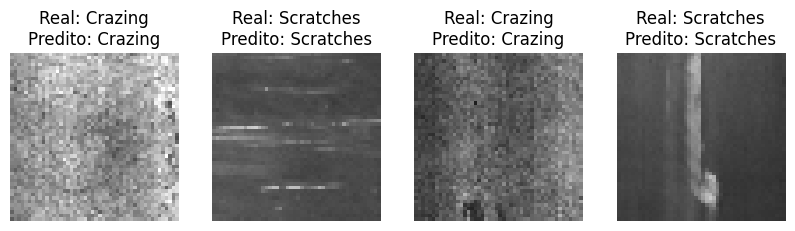

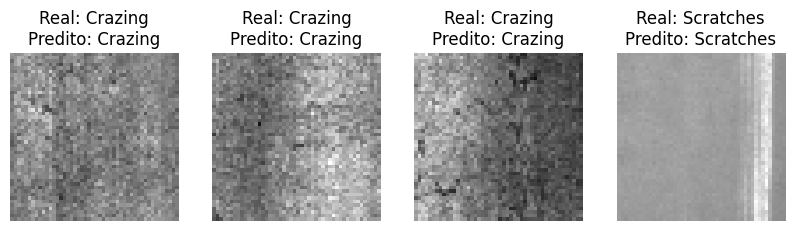

In [31]:
#Resultado das predições

n = 4
for t in range(4):
    plt.figure(figsize=(10,10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Real: {}\nPredito: {}'.format(classes[np.argmax(y_test[i])], classes[np.argmax(preds[i])]))
        plt.axis('off')
    plt.show()

# **Using the model to classify images**

**1. Load Libraries**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

**2. Google Drive and Path**

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Load the pre-trained model
model_path = '/content/modelosalvo.keras' #'/content/drive/MyDrive/modelosalvo.keras'  # Update this path to match your model's location
model = load_model(model_path)

Mounted at /content/drive


ValueError: File not found: filepath=/content/modelosalvo.keras. Please ensure the file is an accessible `.keras` zip file.

**3. Labels**

In [ ]:
# Define class labels (update these to match your model's classes)
class_labels = ['Crazing', 'Scratches']

**4. Preprocessing images**

In [42]:
def preprocess_image(image_path, target_size=(48, 48)):
    """Preprocess image for model input"""
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

5. **Classify Image**

In [43]:
def classify_image(image_path):
    """Classify an image using the pre-trained model"""
    # Preprocess image
    original_img, processed_img = preprocess_image(image_path)

    # Get prediction
    prediction = model.predict(processed_img)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = class_labels[predicted_class_index]
    confidence = prediction[0][predicted_class_index] * 100

    # Display results
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"This image is classified as: {predicted_class.upper()}\nConfidence: {confidence:.2f}%",
              fontsize=16, pad=20)
    plt.show()

    return predicted_class, confidence


**6. Example Usage**

In [48]:
# Example usage
def classify_image_from_drive(relative_path):
    """Classify an image from Google Drive by providing a path relative to MyDrive"""
    full_path = f'/content/drive/MyDrive/Pós-doutorado/Dataset_M_S_T_01/{relative_path}'
    if not os.path.exists(full_path):
        print(f"Error: File not found at {full_path}")
        return

    print(f"Processing image: {relative_path}")
    predicted_class, confidence = classify_image(full_path)
    print(f"Classification result: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")


**7. Function to let user input path**

In [2]:
# Function to let user input a path
def classify_from_user_input():
    image_path = input("Enter the path to your image relative to Google Drive root (e.g., 'metal_surface_model/In_1.bmp'): ")
    classify_image_from_drive(image_path)

# Run the interactive function
classify_from_user_input()

Enter the path to your image relative to Google Drive root (e.g., 'metal_surface_model/In_1.bmp'): /In_1.bmp


NameError: name 'classify_image_from_drive' is not defined